# Explore Dataset
Please contact ouwen@gradienthealth.io about access to this demo notebook.

### Import Dependencies

In [1]:
import hub
import tensorflow as tf
from helper import visualize, get_model, to_model_fit, get_token

### Load the Dataset
Get the structure of the dataset schema and load the shape

In [2]:
ds = hub.Dataset("s3://snark-gradient-raw-data/transform_50_20000_x-test-3/ds3", token=get_token())
ds.schema 
ds.shape

(1000000,)

### Visualize the data
Access any other sample and visualize first image in the sequence

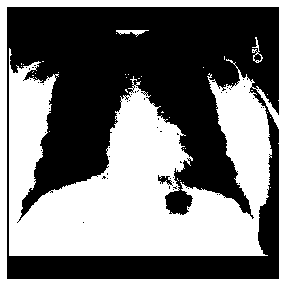

In [4]:
image_sequence = ds["image", 0].compute() 
visualize(image_sequence[0])

### Subset and Filter
Take a subset of the dataset and filter based on only on frontal datasets

In [5]:
subset = ds[500:1000] 
def only_frontal(sample):
    viewPosition = sample["viewPosition"].compute(True)
    return True if "PA" in viewPosition or "AP" in viewPosition else False

filtered = subset.filter(only_frontal)


### Train
Alternatively we can send a subset of keys to t that are relevant for training
This is faster as otherwise other irrelevant data is fetched too, that can slow things down
converts the data into X, y format format for training, then we
batch and prefetch

In [6]:
tds = filtered.to_tensorflow()
tds = filtered.to_tensorflow(key_list=["image", "label_chexpert", "viewPosition"])
tds_train = tds.map(to_model_fit)
tds_train = tds_train.batch(8).prefetch(tf.data.AUTOTUNE)

In [7]:
model = get_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0     

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=['mse', 'mae'],
              loss_weights=[0.5, 0.5],
              metrics=['mse', 'mae'])

model.fit(tds_train,
          steps_per_epoch=50,
          validation_steps=7,
          epochs=1,
          verbose=1)

50/50 [==============================] - 14s 94ms/step - loss: 3.5857 - mse: 7.1714 - mae: 2.5643
